In [1]:
import math
import time
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from data.data_loader import make_loader, XRays_CT_Dataset


from models.unet2d import unet
from models.fullmodel import MultiViewCT
from utils.metrics import psnr
from utils.volume_vis import show_triptych

In [2]:
ANGLES_DEG = [0, 45, 90, 135, 180]
ROOT = "../dataset"
DRR_SIZE = (128, 128)
CT_SIZE  = (128, 128, 128)


CKPT_DIR = Path("./checkpoints_model_mask")
CKPT_DIR.mkdir(parents=True, exist_ok=True)


EPOCHS        = 4000
BASE_LR       = 1e-5
WEIGHT_DECAY  = 1e-5
N_SAMPLES     = 262144
CHUNK_POINTS  = 8192
WARMUP_EPOCHS = 5
FG_RATIO    = 0.7 
FG_THR      = 0.01

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
net2d = unet().to(device)
model = MultiViewCT(
    unet_2d=net2d,
    Z=CT_SIZE[0], Y=CT_SIZE[1], X=CT_SIZE[2],
    feat_ch=128,       # must match U-Net output channels
    pe_dim=9,
    inr_hidden=128,
    inr_blocks_view=3,
    inr_blocks_global=2,
    emb_dim=128,
    inr_out=1
).to(device)

print("Model ready on", device)

Model ready on cuda


In [5]:
loader = make_loader(
    root=ROOT,
    angles_deg=ANGLES_DEG,
    drr_size=DRR_SIZE,
    ct_size=CT_SIZE,
    batch_size=1,
    shuffle=True,
)

subset_loader = DataLoader(
    torch.utils.data.Subset(loader.dataset, [i for i in range(200)]),
    batch_size=1,
    shuffle=False,
)

len(subset_loader), len(loader.dataset)

(200, 266)

In [6]:

crit = nn.MSELoss()

optimG = optim.Adam(
    model.parameters(),
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
)

def lr_lambda(epoch):
    """
    - Linear warmup from 0 -> 1 during WARMUP_EPOCHS.
    - Then cosine decay from 1 -> 0.3.
    """
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(WARMUP_EPOCHS)
    else:
        t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
        cosine = 0.5 * (1 + math.cos(math.pi * t))  # 1 -> 0
        min_factor = 0.3
        return min_factor + (1 - min_factor) * cosine

scheduler = optim.lr_scheduler.LambdaLR(optimG, lr_lambda=lr_lambda)

# Training

In [7]:
def make_scheduler(optimG, last_epoch):
    return torch.optim.lr_scheduler.LambdaLR(
        optimG,
        lr_lambda=lr_lambda,
        last_epoch=last_epoch
    )

In [8]:
def train_model(
    model,
    optimG,
    scheduler_fn,
    CKPT_DIR,
    resume_epoch=None,
    total_epochs=EPOCHS,
):
    """
    Train or resume the model.

    model:      the neural network
    optimG:     optimizer instance
    scheduler_fn: a function that returns a scheduler given (optimG, start_epoch)
    CKPT_DIR:   folder containing checkpoints
    resume_epoch:
        None  : resume from latest checkpoint if any exists
        int>0 : resume from a specific epoch
        <=0   : start from scratch
    total_epochs:
        maximum number of epochs to train
    """

    start_epoch = 0
    ckpt_path = None

    ckpt_files = sorted(CKPT_DIR.glob("model_epoch*.pt"))

    if resume_epoch is None:
        # Use the latest checkpoint if any exists
        if ckpt_files:
            ckpt_path = ckpt_files[-1]

    elif isinstance(resume_epoch, int) and resume_epoch > 0:
        # Use a specific epoch checkpoint
        ckpt_name = f"model_epoch{resume_epoch:04d}.pt"
        candidate = CKPT_DIR / ckpt_name
        if candidate.exists():
            ckpt_path = candidate
        else:
            raise FileNotFoundError(f"Checkpoint not found: {candidate}")

    else:
        # resume_epoch <= 0 → start from scratch
        ckpt_path = None

    if ckpt_path is not None:
        print(f"Resuming from checkpoint: {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimG.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt.get("epoch", 0)

    else:
        print("No checkpoint loaded, starting from scratch.")
        start_epoch = 0

    # Recreate scheduler with the correct last_epoch
    scheduler = scheduler_fn(optimG, last_epoch=start_epoch - 1)

    print(f"Training will start at epoch {start_epoch+1} / {total_epochs}")
    print("Start training")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        running_loss = 0.0
        n_batches = len(subset_loader)

        for batch_idx, batch in enumerate(subset_loader):
            views  = batch["views"].to(device, dtype=torch.float32)    # (B, V, 1, H, W)
            angles = batch["angles"].to(device, dtype=torch.float32)   # (B, V)
            ct     = batch["ct"].to(device, dtype=torch.float32)       # (B, 1, Z, Y, X)

            # Handle shape (B, 1, 1, Z, Y, X) : squeeze extra dim
            if ct.ndim == 6 and ct.shape[2] == 1:
                ct = ct.squeeze(2)

            B, _, Z, Y, X = ct.shape
            N_vox = Z * Y * X

            assert N_vox == model.coords.shape[0], (
                f"Grid mismatch: ct has {N_vox} voxels, "
                f"coords has {model.coords.shape[0]}"
            )

            # Random voxel sampling
            n_use = min(N_SAMPLES, N_vox)
            perm  = torch.randperm(N_vox, device=device)
            idx   = perm[:n_use]

            ct_flat = ct.view(B, -1)
            gt      = ct_flat[:, idx]

            # Forward only on sampled points
            optimG.zero_grad(set_to_none=True)
            pred = model.forward_points(
                views, angles, idx, chunk=CHUNK_POINTS
            )

            loss = crit(pred, gt)
            loss.backward()
            optimG.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 20 == 0:
                print(
                    f"  epoch {epoch+1} | batch {batch_idx+1}/{n_batches} "
                    f"| loss={loss.item():.4e}",
                    end="\r",
                )

        avg_mse  = running_loss / n_batches
        avg_psnr = psnr(avg_mse)
        current_lr = optimG.param_groups[0]["lr"]

        print(
            f"Epoch {epoch+1}/{total_epochs} "
            f"LR:{current_lr:.2e} | "
            f"MSE(subset):{avg_mse:.4e} | PSNR~:{avg_psnr:.2f} dB"
        )

        scheduler.step()

        # Full-volume visualisation every 20 epochs
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                sample = loader.dataset[0]
                v = sample["views"].unsqueeze(0).to(device, dtype=torch.float32)
                a = sample["angles"].unsqueeze(0).to(device, dtype=torch.float32)
                ct_ref = sample["ct"].unsqueeze(0).to(device, dtype=torch.float32)
                if ct_ref.ndim == 6 and ct_ref.shape[2] == 1:
                    ct_ref = ct_ref.squeeze(2)
                pred_full = model(v, a, chunk=CHUNK_POINTS)

            show_triptych(
                pred_full[0, 0].cpu().numpy(),
                ct_ref[0, 0].cpu().numpy(),
                title_prefix=f"Epoch {epoch+1} (full volume)",
            )
            model.train()

        # Checkpoints
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            ckpt_path = CKPT_DIR / f"model_epoch{epoch+1:04d}.pt"
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimG.state_dict(),
                    "loss": avg_mse,
                },
                ckpt_path,
            )
            print(f"Checkpoint : {ckpt_path}")


In [9]:
def train_model_new(
    model,
    optimG,
    scheduler_fn,
    CKPT_DIR,
    resume_epoch=None,
    total_epochs=EPOCHS,
):
    """
    Train or resume the model.

    model:      the neural network
    optimG:     optimizer instance
    scheduler_fn: a function that returns a scheduler given (optimG, start_epoch)
    CKPT_DIR:   folder containing checkpoints
    resume_epoch:
        None  : resume from latest checkpoint if any exists
        int>0 : resume from a specific epoch
        <=0   : start from scratch
    total_epochs:
        maximum number of epochs to train
    """

    start_epoch = 0
    ckpt_path = None

    ckpt_files = sorted(CKPT_DIR.glob("model_epoch*.pt"))

    if resume_epoch is None:
        # Use the latest checkpoint if any exists
        if ckpt_files:
            ckpt_path = ckpt_files[-1]

    elif isinstance(resume_epoch, int) and resume_epoch > 0:
        # Use a specific epoch checkpoint
        ckpt_name = f"model_epoch{resume_epoch:04d}.pt"
        candidate = CKPT_DIR / ckpt_name
        if candidate.exists():
            ckpt_path = candidate
        else:
            raise FileNotFoundError(f"Checkpoint not found: {candidate}")

    else:
        # resume_epoch <= 0 → start from scratch
        ckpt_path = None

    if ckpt_path is not None:
        print(f"Resuming from checkpoint: {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimG.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt.get("epoch", 0)

    else:
        print("No checkpoint loaded, starting from scratch.")
        start_epoch = 0

    # Recreate scheduler with the correct last_epoch
    scheduler = scheduler_fn(optimG, last_epoch=start_epoch - 1)

    print(f"Training will start at epoch {start_epoch+1} / {total_epochs}")
    print("Start training")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        running_loss = 0.0
        n_batches = len(subset_loader)

        for batch_idx, batch in enumerate(subset_loader):
            views  = batch["views"].to(device, dtype=torch.float32)    # (B, V, 1, H, W)
            angles = batch["angles"].to(device, dtype=torch.float32)   # (B, V)
            ct     = batch["ct"].to(device, dtype=torch.float32)       # (B, 1, Z, Y, X)

            # Handle shape (B, 1, 1, Z, Y, X) : squeeze extra dim
            if ct.ndim == 6 and ct.shape[2] == 1:
                ct = ct.squeeze(2)

            B, _, Z, Y, X = ct.shape
            N_vox = Z * Y * X

            assert N_vox == model.coords.shape[0], (
                f"Grid mismatch: ct has {N_vox} voxels, "
                f"coords has {model.coords.shape[0]}"
            )

            # ------------------------------------------------
            #   Foreground / background voxel sampling
            #   avec un mask propre à chaque CT du batch
            # ------------------------------------------------
            optimG.zero_grad(set_to_none=True)
            batch_loss = 0.0

            for b in range(B):
                # CT / vues / angles pour un seul patient
                ct_b     = ct[b:b+1]          # (1,1,Z,Y,X)
                views_b  = views[b:b+1]       # (1,V,1,H,W)
                angles_b = angles[b:b+1]      # (1,V)

                n_use = min(N_SAMPLES, N_vox)

                # Foreground défini sur ce CT uniquement
                # CT normalisé 0–1 : voxels > FG_THR = "intéressants"
                ct_ref = ct_b[0, 0]                 # (Z, Y, X)
                mask_fg = ct_ref > FG_THR           # bool

                mask_flat = mask_fg.view(-1)        # (N_vox,)

                fg_pool = torch.nonzero(mask_flat, as_tuple=False).squeeze(1)
                bg_pool = torch.nonzero(~mask_flat, as_tuple=False).squeeze(1)

                if fg_pool.numel() == 0:
                    # aucun foreground détecté → fallback uniforme
                    perm = torch.randperm(N_vox, device=device)
                    idx_b  = perm[:n_use]
                else:
                    # nombre de samples foreground / background
                    n_fg = int(FG_RATIO * n_use)
                    n_fg = min(n_fg, fg_pool.numel())   # clamp si peu de FG
                    n_bg = n_use - n_fg

                    if bg_pool.numel() == 0:
                        # aucun background : tout en FG
                        idx_fg = fg_pool[torch.randint(
                            0, fg_pool.numel(), (n_use,),
                            device=device
                        )]
                        idx_b = idx_fg
                    else:
                        # échantillonnage aléatoire FG / BG
                        idx_fg = fg_pool[torch.randint(
                            0, fg_pool.numel(), (n_fg,),
                            device=device
                        )]

                        if n_bg > bg_pool.numel():
                            idx_bg = bg_pool[torch.randint(
                                0, bg_pool.numel(), (n_bg,),
                                device=device
                            )]
                        else:
                            perm_bg = torch.randperm(bg_pool.numel(), device=device)
                            idx_bg = bg_pool[perm_bg[:n_bg]]

                        idx_b = torch.cat([idx_fg, idx_bg], dim=0)

                    # shuffle pour mélanger FG et BG
                    perm_idx = torch.randperm(idx_b.numel(), device=device)
                    idx_b = idx_b[perm_idx]

                # GT et prédiction pour ce CT
                ct_flat_b = ct_b.view(1, -1)       # (1, N_vox)
                gt_b      = ct_flat_b[:, idx_b]    # (1, n_use)

                pred_b = model.forward_points(
                    views_b, angles_b, idx_b, chunk=CHUNK_POINTS
                )

                loss_b = crit(pred_b, gt_b)
                batch_loss = batch_loss + loss_b

            # moyenne de la loss sur le batch
            batch_loss = batch_loss / B
            batch_loss.backward()
            optimG.step()

            running_loss += batch_loss.item()

            if (batch_idx + 1) % 20 == 0:
                print(
                    f"  epoch {epoch+1} | batch {batch_idx+1}/{n_batches} "
                    f"| loss={batch_loss.item():.4e}",
                    end="\r",
                )

        avg_mse  = running_loss / n_batches
        avg_psnr = psnr(avg_mse)
        current_lr = optimG.param_groups[0]["lr"]

        print(
            f"Epoch {epoch+1}/{total_epochs} "
            f"LR:{current_lr:.2e} | "
            f"MSE(subset):{avg_mse:.4e} | PSNR~:{avg_psnr:.2f} dB"
        )

        scheduler.step()

        # Full-volume visualisation every 20 epochs
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                sample = loader.dataset[0]
                v = sample["views"].unsqueeze(0).to(device, dtype=torch.float32)
                a = sample["angles"].unsqueeze(0).to(device, dtype=torch.float32)
                ct_ref_full = sample["ct"].unsqueeze(0).to(device, dtype=torch.float32)
                if ct_ref_full.ndim == 6 and ct_ref_full.shape[2] == 1:
                    ct_ref_full = ct_ref_full.squeeze(2)
                pred_full = model(v, a, chunk=CHUNK_POINTS)

            show_triptych(
                pred_full[0, 0].cpu().numpy(),
                ct_ref_full[0, 0].cpu().numpy(),
                title_prefix=f"Epoch {epoch+1} (full volume)",
            )
            model.train()

        # Checkpoints
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            ckpt_path = CKPT_DIR / f"model_epoch{epoch+1:04d}.pt"
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimG.state_dict(),
                    "loss": avg_mse,
                },
                ckpt_path,
            )
            print(f"Checkpoint : {ckpt_path}")


Resuming from checkpoint: checkpoints_model_mask/model_epoch0820.pt
Training will start at epoch 821 / 4000
Start training
Epoch 821/4000 LR:9.31e-06 | MSE(subset):5.8149e-03 | PSNR~:22.35 dB
Epoch 822/4000 LR:9.30e-06 | MSE(subset):5.9333e-03 | PSNR~:22.27 dB
Epoch 823/4000 LR:9.30e-06 | MSE(subset):5.7888e-03 | PSNR~:22.37 dB
Epoch 824/4000 LR:9.30e-06 | MSE(subset):5.7693e-03 | PSNR~:22.39 dB
Epoch 825/4000 LR:9.30e-06 | MSE(subset):5.7589e-03 | PSNR~:22.40 dB
Epoch 826/4000 LR:9.30e-06 | MSE(subset):5.8773e-03 | PSNR~:22.31 dB
Epoch 827/4000 LR:9.30e-06 | MSE(subset):6.0493e-03 | PSNR~:22.18 dB
Epoch 828/4000 LR:9.29e-06 | MSE(subset):6.0334e-03 | PSNR~:22.19 dB
Epoch 829/4000 LR:9.29e-06 | MSE(subset):5.8880e-03 | PSNR~:22.30 dB
Epoch 830/4000 LR:9.29e-06 | MSE(subset):5.8637e-03 | PSNR~:22.32 dB
Checkpoint : checkpoints_model_mask/model_epoch0830.pt
Epoch 831/4000 LR:9.29e-06 | MSE(subset):6.0075e-03 | PSNR~:22.21 dB
Epoch 832/4000 LR:9.29e-06 | MSE(subset):5.8922e-03 | PSNR~:22.

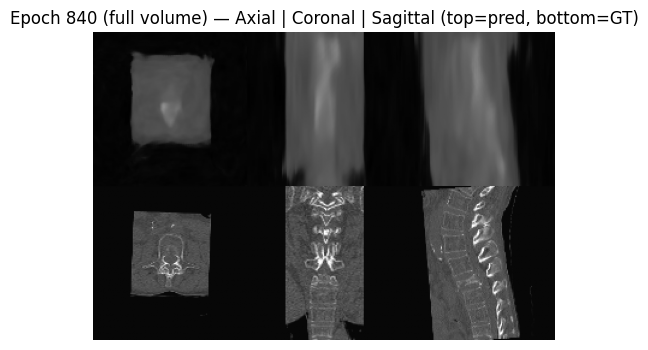

Checkpoint : checkpoints_model_mask/model_epoch0840.pt
Epoch 841/4000 LR:9.27e-06 | MSE(subset):5.8787e-03 | PSNR~:22.31 dB
Epoch 842/4000 LR:9.27e-06 | MSE(subset):5.8355e-03 | PSNR~:22.34 dB
Epoch 843/4000 LR:9.27e-06 | MSE(subset):5.7784e-03 | PSNR~:22.38 dB
Epoch 844/4000 LR:9.27e-06 | MSE(subset):5.7857e-03 | PSNR~:22.38 dB
Epoch 845/4000 LR:9.27e-06 | MSE(subset):5.7881e-03 | PSNR~:22.37 dB
Epoch 846/4000 LR:9.26e-06 | MSE(subset):5.8899e-03 | PSNR~:22.30 dB
Epoch 847/4000 LR:9.26e-06 | MSE(subset):5.8778e-03 | PSNR~:22.31 dB
Epoch 848/4000 LR:9.26e-06 | MSE(subset):5.8420e-03 | PSNR~:22.33 dB
Epoch 849/4000 LR:9.26e-06 | MSE(subset):5.8635e-03 | PSNR~:22.32 dB
Epoch 850/4000 LR:9.26e-06 | MSE(subset):5.8009e-03 | PSNR~:22.37 dB
Checkpoint : checkpoints_model_mask/model_epoch0850.pt
Epoch 851/4000 LR:9.26e-06 | MSE(subset):5.8129e-03 | PSNR~:22.36 dB
Epoch 852/4000 LR:9.25e-06 | MSE(subset):5.7713e-03 | PSNR~:22.39 dB
Epoch 853/4000 LR:9.25e-06 | MSE(subset):5.7705e-03 | PSNR~:22

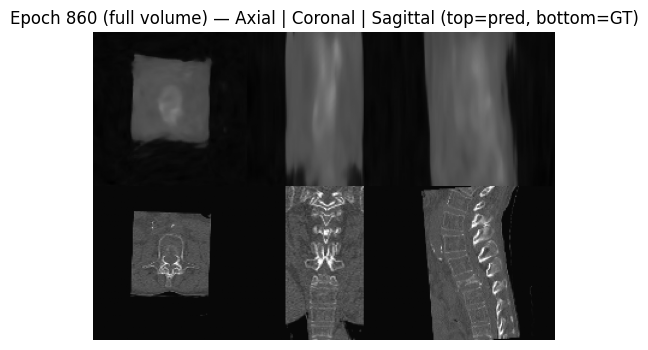

Checkpoint : checkpoints_model_mask/model_epoch0860.pt
Epoch 861/4000 LR:9.24e-06 | MSE(subset):5.9515e-03 | PSNR~:22.25 dB
Epoch 862/4000 LR:9.24e-06 | MSE(subset):5.9593e-03 | PSNR~:22.25 dB
Epoch 863/4000 LR:9.23e-06 | MSE(subset):6.0852e-03 | PSNR~:22.16 dB
Epoch 864/4000 LR:9.23e-06 | MSE(subset):6.0190e-03 | PSNR~:22.20 dB
Epoch 865/4000 LR:9.23e-06 | MSE(subset):5.9363e-03 | PSNR~:22.26 dB
Epoch 866/4000 LR:9.23e-06 | MSE(subset):6.0090e-03 | PSNR~:22.21 dB
Epoch 867/4000 LR:9.23e-06 | MSE(subset):5.9224e-03 | PSNR~:22.28 dB
Epoch 868/4000 LR:9.23e-06 | MSE(subset):5.8425e-03 | PSNR~:22.33 dB
Epoch 869/4000 LR:9.22e-06 | MSE(subset):5.7704e-03 | PSNR~:22.39 dB
Epoch 870/4000 LR:9.22e-06 | MSE(subset):5.8446e-03 | PSNR~:22.33 dB
Checkpoint : checkpoints_model_mask/model_epoch0870.pt
Epoch 871/4000 LR:9.22e-06 | MSE(subset):5.7450e-03 | PSNR~:22.41 dB
Epoch 872/4000 LR:9.22e-06 | MSE(subset):5.6774e-03 | PSNR~:22.46 dB
Epoch 873/4000 LR:9.22e-06 | MSE(subset):5.7957e-03 | PSNR~:22

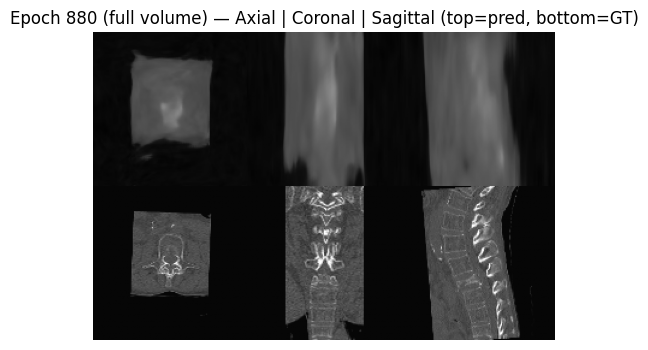

Checkpoint : checkpoints_model_mask/model_epoch0880.pt
Epoch 881/4000 LR:9.20e-06 | MSE(subset):5.7705e-03 | PSNR~:22.39 dB
Epoch 882/4000 LR:9.20e-06 | MSE(subset):5.7172e-03 | PSNR~:22.43 dB
Epoch 883/4000 LR:9.20e-06 | MSE(subset):5.7332e-03 | PSNR~:22.42 dB
Epoch 884/4000 LR:9.20e-06 | MSE(subset):5.7179e-03 | PSNR~:22.43 dB
Epoch 885/4000 LR:9.20e-06 | MSE(subset):5.8077e-03 | PSNR~:22.36 dB
Epoch 886/4000 LR:9.19e-06 | MSE(subset):5.7973e-03 | PSNR~:22.37 dB
Epoch 887/4000 LR:9.19e-06 | MSE(subset):5.7129e-03 | PSNR~:22.43 dB
Epoch 888/4000 LR:9.19e-06 | MSE(subset):5.6904e-03 | PSNR~:22.45 dB
Epoch 889/4000 LR:9.19e-06 | MSE(subset):5.6048e-03 | PSNR~:22.51 dB
Epoch 890/4000 LR:9.19e-06 | MSE(subset):5.6608e-03 | PSNR~:22.47 dB
Checkpoint : checkpoints_model_mask/model_epoch0890.pt
Epoch 891/4000 LR:9.19e-06 | MSE(subset):5.6151e-03 | PSNR~:22.51 dB
Epoch 892/4000 LR:9.18e-06 | MSE(subset):5.6203e-03 | PSNR~:22.50 dB
Epoch 893/4000 LR:9.18e-06 | MSE(subset):5.7783e-03 | PSNR~:22

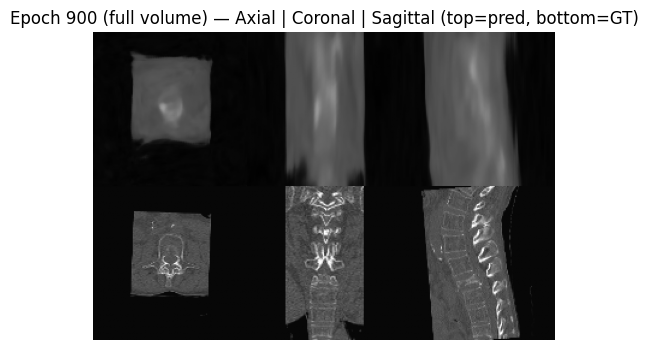

Checkpoint : checkpoints_model_mask/model_epoch0900.pt
Epoch 901/4000 LR:9.17e-06 | MSE(subset):5.7963e-03 | PSNR~:22.37 dB
Epoch 902/4000 LR:9.17e-06 | MSE(subset):5.7351e-03 | PSNR~:22.41 dB
Epoch 903/4000 LR:9.16e-06 | MSE(subset):5.7573e-03 | PSNR~:22.40 dB
Epoch 904/4000 LR:9.16e-06 | MSE(subset):5.6701e-03 | PSNR~:22.46 dB
Epoch 905/4000 LR:9.16e-06 | MSE(subset):5.6103e-03 | PSNR~:22.51 dB
Epoch 906/4000 LR:9.16e-06 | MSE(subset):5.6143e-03 | PSNR~:22.51 dB
Epoch 907/4000 LR:9.16e-06 | MSE(subset):5.7793e-03 | PSNR~:22.38 dB
Epoch 908/4000 LR:9.16e-06 | MSE(subset):5.7689e-03 | PSNR~:22.39 dB
Epoch 909/4000 LR:9.15e-06 | MSE(subset):5.6830e-03 | PSNR~:22.45 dB
Epoch 910/4000 LR:9.15e-06 | MSE(subset):5.7284e-03 | PSNR~:22.42 dB
Checkpoint : checkpoints_model_mask/model_epoch0910.pt
Epoch 911/4000 LR:9.15e-06 | MSE(subset):5.6453e-03 | PSNR~:22.48 dB
Epoch 912/4000 LR:9.15e-06 | MSE(subset):5.7421e-03 | PSNR~:22.41 dB
Epoch 913/4000 LR:9.15e-06 | MSE(subset):5.6365e-03 | PSNR~:22

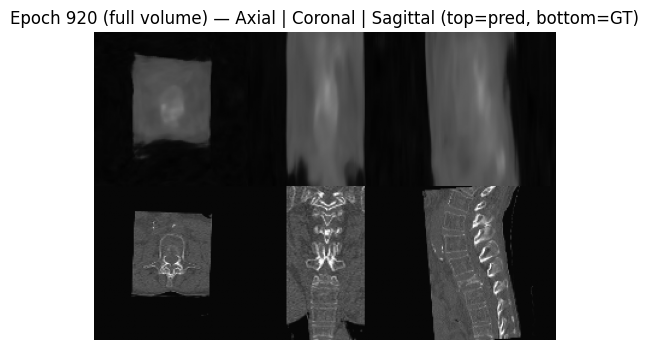

Checkpoint : checkpoints_model_mask/model_epoch0920.pt
Epoch 921/4000 LR:9.13e-06 | MSE(subset):5.7812e-03 | PSNR~:22.38 dB
Epoch 922/4000 LR:9.13e-06 | MSE(subset):5.8042e-03 | PSNR~:22.36 dB
Epoch 923/4000 LR:9.13e-06 | MSE(subset):5.9126e-03 | PSNR~:22.28 dB
Epoch 924/4000 LR:9.13e-06 | MSE(subset):5.7967e-03 | PSNR~:22.37 dB
Epoch 925/4000 LR:9.13e-06 | MSE(subset):5.6969e-03 | PSNR~:22.44 dB
Epoch 926/4000 LR:9.12e-06 | MSE(subset):5.6845e-03 | PSNR~:22.45 dB
Epoch 927/4000 LR:9.12e-06 | MSE(subset):5.7599e-03 | PSNR~:22.40 dB
Epoch 928/4000 LR:9.12e-06 | MSE(subset):5.9019e-03 | PSNR~:22.29 dB
Epoch 929/4000 LR:9.12e-06 | MSE(subset):5.9108e-03 | PSNR~:22.28 dB
Epoch 930/4000 LR:9.12e-06 | MSE(subset):5.9524e-03 | PSNR~:22.25 dB
Checkpoint : checkpoints_model_mask/model_epoch0930.pt
Epoch 931/4000 LR:9.11e-06 | MSE(subset):5.8204e-03 | PSNR~:22.35 dB
Epoch 932/4000 LR:9.11e-06 | MSE(subset):5.8531e-03 | PSNR~:22.33 dB
Epoch 933/4000 LR:9.11e-06 | MSE(subset):5.7045e-03 | PSNR~:22

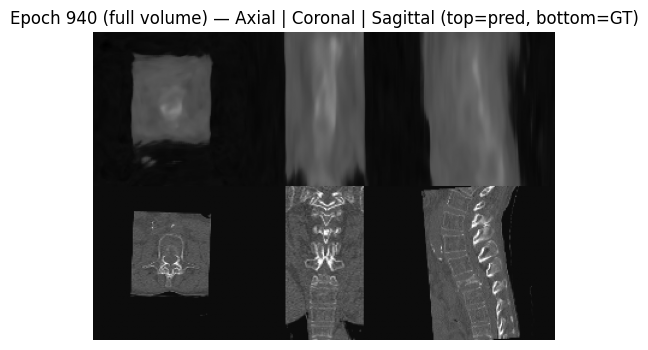

Checkpoint : checkpoints_model_mask/model_epoch0940.pt
Epoch 941/4000 LR:9.10e-06 | MSE(subset):5.5440e-03 | PSNR~:22.56 dB
Epoch 942/4000 LR:9.09e-06 | MSE(subset):5.5548e-03 | PSNR~:22.55 dB
Epoch 943/4000 LR:9.09e-06 | MSE(subset):5.5637e-03 | PSNR~:22.55 dB
Epoch 944/4000 LR:9.09e-06 | MSE(subset):5.5022e-03 | PSNR~:22.59 dB
Epoch 945/4000 LR:9.09e-06 | MSE(subset):5.5977e-03 | PSNR~:22.52 dB
Epoch 946/4000 LR:9.09e-06 | MSE(subset):5.5000e-03 | PSNR~:22.60 dB
Epoch 947/4000 LR:9.08e-06 | MSE(subset):5.4978e-03 | PSNR~:22.60 dB
Epoch 948/4000 LR:9.08e-06 | MSE(subset):5.5463e-03 | PSNR~:22.56 dB
Epoch 949/4000 LR:9.08e-06 | MSE(subset):5.6146e-03 | PSNR~:22.51 dB
Epoch 950/4000 LR:9.08e-06 | MSE(subset):5.5898e-03 | PSNR~:22.53 dB
Checkpoint : checkpoints_model_mask/model_epoch0950.pt
Epoch 951/4000 LR:9.08e-06 | MSE(subset):5.4391e-03 | PSNR~:22.64 dB
Epoch 952/4000 LR:9.08e-06 | MSE(subset):5.6684e-03 | PSNR~:22.47 dB
Epoch 953/4000 LR:9.07e-06 | MSE(subset):5.6380e-03 | PSNR~:22

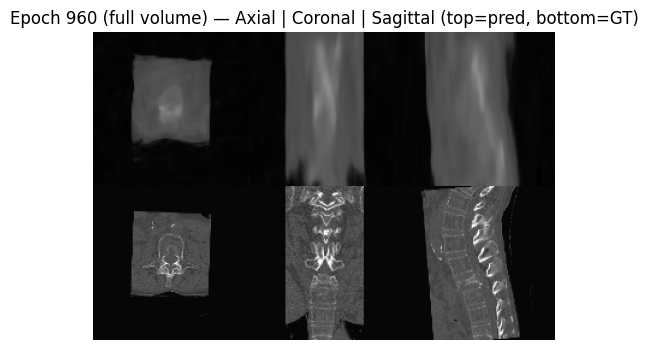

Checkpoint : checkpoints_model_mask/model_epoch0960.pt
Epoch 961/4000 LR:9.06e-06 | MSE(subset):5.5976e-03 | PSNR~:22.52 dB
Epoch 962/4000 LR:9.06e-06 | MSE(subset):5.4981e-03 | PSNR~:22.60 dB
Epoch 963/4000 LR:9.05e-06 | MSE(subset):5.4338e-03 | PSNR~:22.65 dB
Epoch 964/4000 LR:9.05e-06 | MSE(subset):5.6375e-03 | PSNR~:22.49 dB
Epoch 965/4000 LR:9.05e-06 | MSE(subset):5.6330e-03 | PSNR~:22.49 dB
Epoch 966/4000 LR:9.05e-06 | MSE(subset):5.5461e-03 | PSNR~:22.56 dB
Epoch 967/4000 LR:9.05e-06 | MSE(subset):5.6019e-03 | PSNR~:22.52 dB
Epoch 968/4000 LR:9.05e-06 | MSE(subset):5.6096e-03 | PSNR~:22.51 dB
Epoch 969/4000 LR:9.04e-06 | MSE(subset):5.5828e-03 | PSNR~:22.53 dB
Epoch 970/4000 LR:9.04e-06 | MSE(subset):5.5130e-03 | PSNR~:22.59 dB
Checkpoint : checkpoints_model_mask/model_epoch0970.pt
Epoch 971/4000 LR:9.04e-06 | MSE(subset):5.5128e-03 | PSNR~:22.59 dB
Epoch 972/4000 LR:9.04e-06 | MSE(subset):5.5962e-03 | PSNR~:22.52 dB
Epoch 973/4000 LR:9.04e-06 | MSE(subset):5.6127e-03 | PSNR~:22

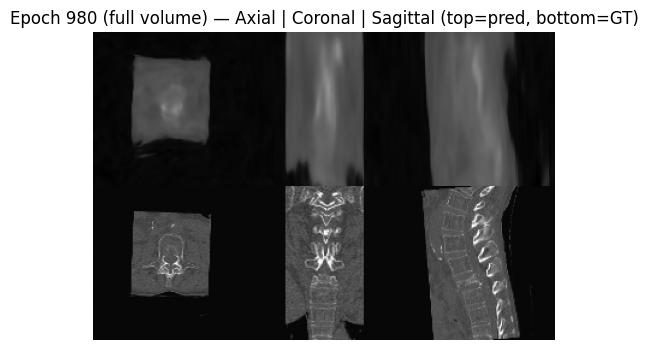

Checkpoint : checkpoints_model_mask/model_epoch0980.pt
Epoch 981/4000 LR:9.02e-06 | MSE(subset):5.7287e-03 | PSNR~:22.42 dB
Epoch 982/4000 LR:9.02e-06 | MSE(subset):5.6375e-03 | PSNR~:22.49 dB
Epoch 983/4000 LR:9.02e-06 | MSE(subset):5.6562e-03 | PSNR~:22.47 dB
Epoch 984/4000 LR:9.01e-06 | MSE(subset):5.7593e-03 | PSNR~:22.40 dB
Epoch 985/4000 LR:9.01e-06 | MSE(subset):5.7689e-03 | PSNR~:22.39 dB
Epoch 986/4000 LR:9.01e-06 | MSE(subset):5.8275e-03 | PSNR~:22.35 dB
Epoch 987/4000 LR:9.01e-06 | MSE(subset):5.7089e-03 | PSNR~:22.43 dB
Epoch 988/4000 LR:9.01e-06 | MSE(subset):5.6961e-03 | PSNR~:22.44 dB
Epoch 989/4000 LR:9.01e-06 | MSE(subset):5.6824e-03 | PSNR~:22.45 dB
Epoch 990/4000 LR:9.00e-06 | MSE(subset):5.6391e-03 | PSNR~:22.49 dB
Checkpoint : checkpoints_model_mask/model_epoch0990.pt
Epoch 991/4000 LR:9.00e-06 | MSE(subset):5.5139e-03 | PSNR~:22.59 dB
Epoch 992/4000 LR:9.00e-06 | MSE(subset):5.5380e-03 | PSNR~:22.57 dB
Epoch 993/4000 LR:9.00e-06 | MSE(subset):5.5465e-03 | PSNR~:22

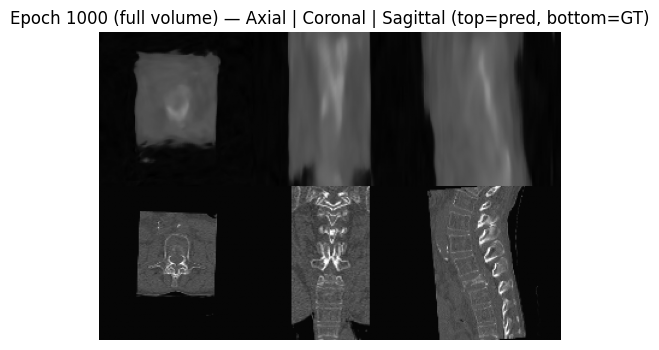

Checkpoint : checkpoints_model_mask/model_epoch1000.pt
Epoch 1001/4000 LR:8.98e-06 | MSE(subset):5.4469e-03 | PSNR~:22.64 dB
Epoch 1002/4000 LR:8.98e-06 | MSE(subset):5.4349e-03 | PSNR~:22.65 dB
Epoch 1003/4000 LR:8.98e-06 | MSE(subset):5.3558e-03 | PSNR~:22.71 dB
Epoch 1004/4000 LR:8.98e-06 | MSE(subset):5.4515e-03 | PSNR~:22.63 dB
Epoch 1005/4000 LR:8.97e-06 | MSE(subset):5.4696e-03 | PSNR~:22.62 dB
Epoch 1006/4000 LR:8.97e-06 | MSE(subset):5.4401e-03 | PSNR~:22.64 dB
Epoch 1007/4000 LR:8.97e-06 | MSE(subset):5.4892e-03 | PSNR~:22.60 dB
Epoch 1008/4000 LR:8.97e-06 | MSE(subset):5.4552e-03 | PSNR~:22.63 dB
Epoch 1009/4000 LR:8.97e-06 | MSE(subset):5.3770e-03 | PSNR~:22.69 dB
Epoch 1010/4000 LR:8.96e-06 | MSE(subset):5.5863e-03 | PSNR~:22.53 dB
Checkpoint : checkpoints_model_mask/model_epoch1010.pt
Epoch 1011/4000 LR:8.96e-06 | MSE(subset):5.5217e-03 | PSNR~:22.58 dB
Epoch 1012/4000 LR:8.96e-06 | MSE(subset):5.5352e-03 | PSNR~:22.57 dB
Epoch 1013/4000 LR:8.96e-06 | MSE(subset):5.4548e-

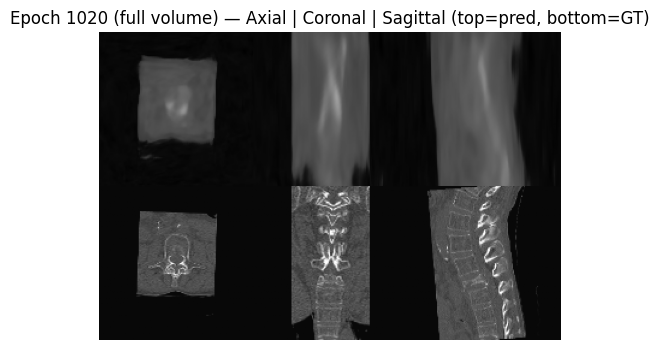

Checkpoint : checkpoints_model_mask/model_epoch1020.pt
Epoch 1021/4000 LR:8.94e-06 | MSE(subset):5.5170e-03 | PSNR~:22.58 dB
Epoch 1022/4000 LR:8.94e-06 | MSE(subset):5.4264e-03 | PSNR~:22.65 dB
Epoch 1023/4000 LR:8.94e-06 | MSE(subset):5.4575e-03 | PSNR~:22.63 dB
Epoch 1024/4000 LR:8.94e-06 | MSE(subset):5.5261e-03 | PSNR~:22.58 dB
Epoch 1025/4000 LR:8.94e-06 | MSE(subset):5.5557e-03 | PSNR~:22.55 dB
Epoch 1026/4000 LR:8.93e-06 | MSE(subset):5.3941e-03 | PSNR~:22.68 dB
Epoch 1027/4000 LR:8.93e-06 | MSE(subset):5.4099e-03 | PSNR~:22.67 dB
Epoch 1028/4000 LR:8.93e-06 | MSE(subset):5.5672e-03 | PSNR~:22.54 dB
Epoch 1029/4000 LR:8.93e-06 | MSE(subset):5.5233e-03 | PSNR~:22.58 dB
Epoch 1030/4000 LR:8.93e-06 | MSE(subset):5.4481e-03 | PSNR~:22.64 dB
Checkpoint : checkpoints_model_mask/model_epoch1030.pt
Epoch 1031/4000 LR:8.92e-06 | MSE(subset):5.4349e-03 | PSNR~:22.65 dB
Epoch 1032/4000 LR:8.92e-06 | MSE(subset):5.5210e-03 | PSNR~:22.58 dB
Epoch 1033/4000 LR:8.92e-06 | MSE(subset):5.4223e-

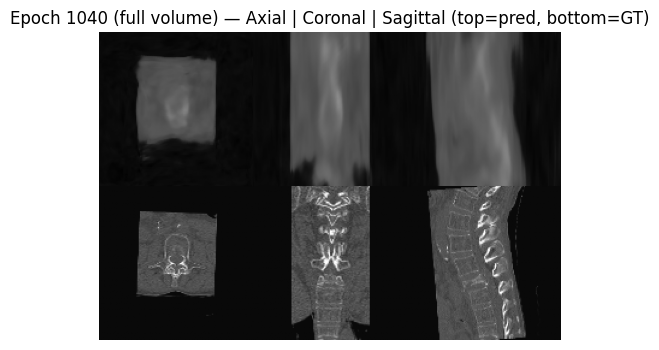

Checkpoint : checkpoints_model_mask/model_epoch1040.pt
Epoch 1041/4000 LR:8.90e-06 | MSE(subset):5.4674e-03 | PSNR~:22.62 dB
Epoch 1042/4000 LR:8.90e-06 | MSE(subset):5.5411e-03 | PSNR~:22.56 dB
Epoch 1043/4000 LR:8.90e-06 | MSE(subset):5.5646e-03 | PSNR~:22.55 dB
Epoch 1044/4000 LR:8.90e-06 | MSE(subset):5.5278e-03 | PSNR~:22.57 dB
Epoch 1045/4000 LR:8.90e-06 | MSE(subset):5.4373e-03 | PSNR~:22.65 dB
Epoch 1046/4000 LR:8.89e-06 | MSE(subset):5.5033e-03 | PSNR~:22.59 dB
Epoch 1047/4000 LR:8.89e-06 | MSE(subset):5.5177e-03 | PSNR~:22.58 dB
Epoch 1048/4000 LR:8.89e-06 | MSE(subset):5.4934e-03 | PSNR~:22.60 dB
Epoch 1049/4000 LR:8.89e-06 | MSE(subset):5.4939e-03 | PSNR~:22.60 dB
Epoch 1050/4000 LR:8.89e-06 | MSE(subset):5.5943e-03 | PSNR~:22.52 dB
Checkpoint : checkpoints_model_mask/model_epoch1050.pt
Epoch 1051/4000 LR:8.88e-06 | MSE(subset):5.4833e-03 | PSNR~:22.61 dB
Epoch 1052/4000 LR:8.88e-06 | MSE(subset):5.5680e-03 | PSNR~:22.54 dB
Epoch 1053/4000 LR:8.88e-06 | MSE(subset):5.5267e-

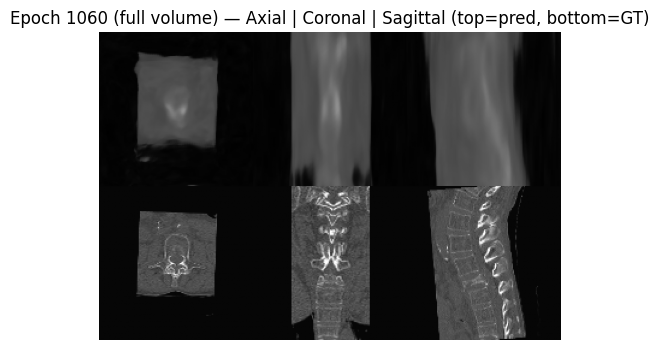

Checkpoint : checkpoints_model_mask/model_epoch1060.pt
Epoch 1061/4000 LR:8.86e-06 | MSE(subset):5.4489e-03 | PSNR~:22.64 dB
Epoch 1062/4000 LR:8.86e-06 | MSE(subset):5.4049e-03 | PSNR~:22.67 dB
Epoch 1063/4000 LR:8.86e-06 | MSE(subset):5.5268e-03 | PSNR~:22.58 dB
Epoch 1064/4000 LR:8.86e-06 | MSE(subset):5.5206e-03 | PSNR~:22.58 dB
Epoch 1065/4000 LR:8.85e-06 | MSE(subset):5.5832e-03 | PSNR~:22.53 dB
Epoch 1066/4000 LR:8.85e-06 | MSE(subset):5.6909e-03 | PSNR~:22.45 dB
Epoch 1067/4000 LR:8.85e-06 | MSE(subset):5.6006e-03 | PSNR~:22.52 dB
Epoch 1068/4000 LR:8.85e-06 | MSE(subset):5.4291e-03 | PSNR~:22.65 dB
Epoch 1069/4000 LR:8.85e-06 | MSE(subset):5.4413e-03 | PSNR~:22.64 dB
Epoch 1070/4000 LR:8.84e-06 | MSE(subset):5.5252e-03 | PSNR~:22.58 dB
Checkpoint : checkpoints_model_mask/model_epoch1070.pt
Epoch 1071/4000 LR:8.84e-06 | MSE(subset):5.4792e-03 | PSNR~:22.61 dB
Epoch 1072/4000 LR:8.84e-06 | MSE(subset):5.6645e-03 | PSNR~:22.47 dB
Epoch 1073/4000 LR:8.84e-06 | MSE(subset):5.5745e-

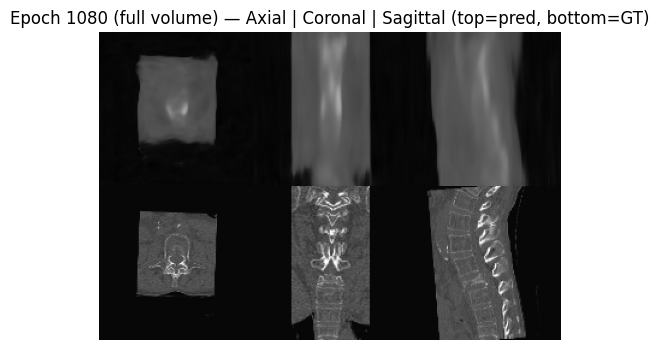

Checkpoint : checkpoints_model_mask/model_epoch1080.pt
Epoch 1081/4000 LR:8.82e-06 | MSE(subset):5.3926e-03 | PSNR~:22.68 dB
Epoch 1082/4000 LR:8.82e-06 | MSE(subset):5.4089e-03 | PSNR~:22.67 dB
Epoch 1083/4000 LR:8.82e-06 | MSE(subset):5.3831e-03 | PSNR~:22.69 dB
Epoch 1084/4000 LR:8.82e-06 | MSE(subset):5.4162e-03 | PSNR~:22.66 dB
Epoch 1085/4000 LR:8.81e-06 | MSE(subset):5.4277e-03 | PSNR~:22.65 dB
Epoch 1086/4000 LR:8.81e-06 | MSE(subset):5.2719e-03 | PSNR~:22.78 dB
Epoch 1087/4000 LR:8.81e-06 | MSE(subset):5.3876e-03 | PSNR~:22.69 dB
Epoch 1088/4000 LR:8.81e-06 | MSE(subset):5.4109e-03 | PSNR~:22.67 dB
Epoch 1089/4000 LR:8.81e-06 | MSE(subset):5.4423e-03 | PSNR~:22.64 dB
Epoch 1090/4000 LR:8.80e-06 | MSE(subset):5.3960e-03 | PSNR~:22.68 dB
Checkpoint : checkpoints_model_mask/model_epoch1090.pt
Epoch 1091/4000 LR:8.80e-06 | MSE(subset):5.7927e-03 | PSNR~:22.37 dB
Epoch 1092/4000 LR:8.80e-06 | MSE(subset):5.5844e-03 | PSNR~:22.53 dB
Epoch 1093/4000 LR:8.80e-06 | MSE(subset):5.4669e-

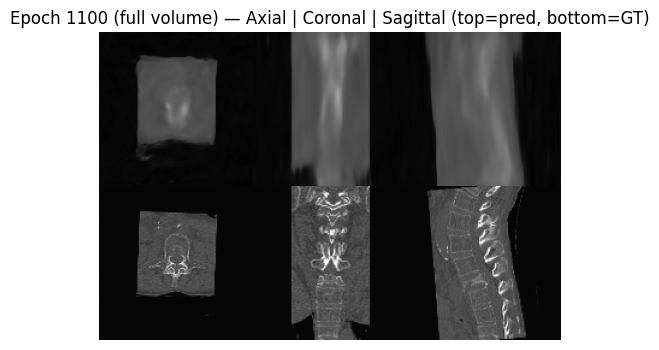

Checkpoint : checkpoints_model_mask/model_epoch1100.pt
Epoch 1101/4000 LR:8.78e-06 | MSE(subset):5.4312e-03 | PSNR~:22.65 dB
Epoch 1102/4000 LR:8.78e-06 | MSE(subset):5.5269e-03 | PSNR~:22.58 dB
Epoch 1103/4000 LR:8.78e-06 | MSE(subset):5.3865e-03 | PSNR~:22.69 dB
Epoch 1104/4000 LR:8.77e-06 | MSE(subset):5.4312e-03 | PSNR~:22.65 dB
Epoch 1105/4000 LR:8.77e-06 | MSE(subset):5.3090e-03 | PSNR~:22.75 dB
Epoch 1106/4000 LR:8.77e-06 | MSE(subset):5.3683e-03 | PSNR~:22.70 dB
Epoch 1107/4000 LR:8.77e-06 | MSE(subset):5.3298e-03 | PSNR~:22.73 dB
Epoch 1108/4000 LR:8.77e-06 | MSE(subset):5.3940e-03 | PSNR~:22.68 dB
Epoch 1109/4000 LR:8.76e-06 | MSE(subset):5.3713e-03 | PSNR~:22.70 dB
Epoch 1110/4000 LR:8.76e-06 | MSE(subset):5.4473e-03 | PSNR~:22.64 dB
Checkpoint : checkpoints_model_mask/model_epoch1110.pt
Epoch 1111/4000 LR:8.76e-06 | MSE(subset):5.3556e-03 | PSNR~:22.71 dB
Epoch 1112/4000 LR:8.76e-06 | MSE(subset):5.3425e-03 | PSNR~:22.72 dB
Epoch 1113/4000 LR:8.76e-06 | MSE(subset):5.2630e-

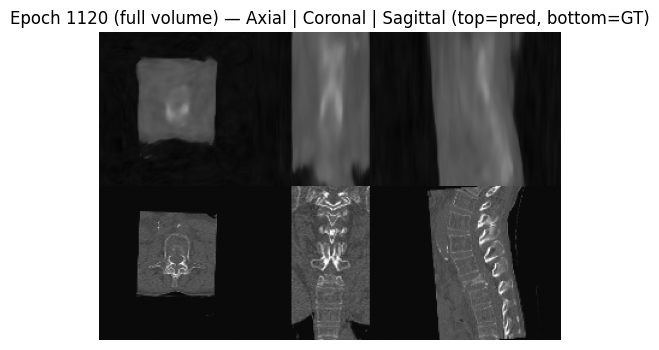

Checkpoint : checkpoints_model_mask/model_epoch1120.pt
Epoch 1121/4000 LR:8.74e-06 | MSE(subset):5.3831e-03 | PSNR~:22.69 dB
Epoch 1122/4000 LR:8.74e-06 | MSE(subset):5.3597e-03 | PSNR~:22.71 dB
Epoch 1123/4000 LR:8.73e-06 | MSE(subset):5.3839e-03 | PSNR~:22.69 dB
Epoch 1124/4000 LR:8.73e-06 | MSE(subset):5.3546e-03 | PSNR~:22.71 dB
Epoch 1125/4000 LR:8.73e-06 | MSE(subset):5.5736e-03 | PSNR~:22.54 dB
Epoch 1126/4000 LR:8.73e-06 | MSE(subset):5.4389e-03 | PSNR~:22.64 dB
Epoch 1127/4000 LR:8.73e-06 | MSE(subset):5.3896e-03 | PSNR~:22.68 dB
Epoch 1128/4000 LR:8.72e-06 | MSE(subset):5.3466e-03 | PSNR~:22.72 dB
Epoch 1129/4000 LR:8.72e-06 | MSE(subset):5.4488e-03 | PSNR~:22.64 dB
Epoch 1130/4000 LR:8.72e-06 | MSE(subset):5.3966e-03 | PSNR~:22.68 dB
Checkpoint : checkpoints_model_mask/model_epoch1130.pt
Epoch 1131/4000 LR:8.72e-06 | MSE(subset):5.3555e-03 | PSNR~:22.71 dB
Epoch 1132/4000 LR:8.72e-06 | MSE(subset):5.4987e-03 | PSNR~:22.60 dB
Epoch 1133/4000 LR:8.71e-06 | MSE(subset):5.4411e-

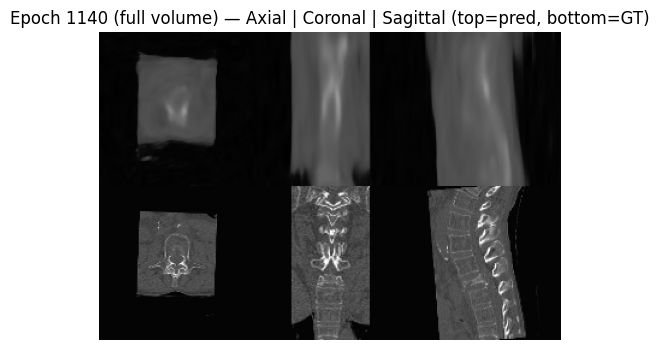

Checkpoint : checkpoints_model_mask/model_epoch1140.pt
Epoch 1141/4000 LR:8.70e-06 | MSE(subset):5.3111e-03 | PSNR~:22.75 dB
Epoch 1142/4000 LR:8.69e-06 | MSE(subset):5.3095e-03 | PSNR~:22.75 dB
Epoch 1143/4000 LR:8.69e-06 | MSE(subset):5.3212e-03 | PSNR~:22.74 dB
Epoch 1144/4000 LR:8.69e-06 | MSE(subset):5.3358e-03 | PSNR~:22.73 dB
Epoch 1145/4000 LR:8.69e-06 | MSE(subset):5.2325e-03 | PSNR~:22.81 dB
Epoch 1146/4000 LR:8.69e-06 | MSE(subset):5.3935e-03 | PSNR~:22.68 dB
Epoch 1147/4000 LR:8.68e-06 | MSE(subset):5.3221e-03 | PSNR~:22.74 dB
Epoch 1148/4000 LR:8.68e-06 | MSE(subset):5.3259e-03 | PSNR~:22.74 dB
Epoch 1149/4000 LR:8.68e-06 | MSE(subset):5.3227e-03 | PSNR~:22.74 dB
Epoch 1150/4000 LR:8.68e-06 | MSE(subset):5.2560e-03 | PSNR~:22.79 dB
Checkpoint : checkpoints_model_mask/model_epoch1150.pt
Epoch 1151/4000 LR:8.67e-06 | MSE(subset):5.3441e-03 | PSNR~:22.72 dB
Epoch 1152/4000 LR:8.67e-06 | MSE(subset):5.4078e-03 | PSNR~:22.67 dB
Epoch 1153/4000 LR:8.67e-06 | MSE(subset):5.4213e-

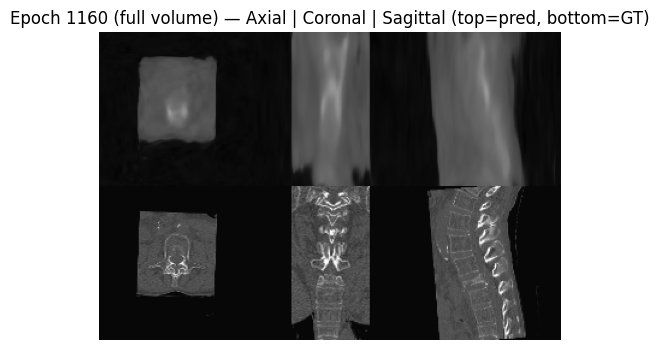

Checkpoint : checkpoints_model_mask/model_epoch1160.pt
Epoch 1161/4000 LR:8.65e-06 | MSE(subset):5.3978e-03 | PSNR~:22.68 dB
Epoch 1162/4000 LR:8.65e-06 | MSE(subset):5.3858e-03 | PSNR~:22.69 dB
Epoch 1163/4000 LR:8.65e-06 | MSE(subset):5.3279e-03 | PSNR~:22.73 dB
Epoch 1164/4000 LR:8.65e-06 | MSE(subset):5.3538e-03 | PSNR~:22.71 dB
Epoch 1165/4000 LR:8.64e-06 | MSE(subset):5.4845e-03 | PSNR~:22.61 dB
Epoch 1166/4000 LR:8.64e-06 | MSE(subset):5.4569e-03 | PSNR~:22.63 dB
Epoch 1167/4000 LR:8.64e-06 | MSE(subset):5.4123e-03 | PSNR~:22.67 dB
Epoch 1168/4000 LR:8.64e-06 | MSE(subset):5.3699e-03 | PSNR~:22.70 dB
Epoch 1169/4000 LR:8.64e-06 | MSE(subset):5.3736e-03 | PSNR~:22.70 dB
Epoch 1170/4000 LR:8.63e-06 | MSE(subset):5.4243e-03 | PSNR~:22.66 dB
Checkpoint : checkpoints_model_mask/model_epoch1170.pt
Epoch 1171/4000 LR:8.63e-06 | MSE(subset):5.3933e-03 | PSNR~:22.68 dB
Epoch 1172/4000 LR:8.63e-06 | MSE(subset):5.3662e-03 | PSNR~:22.70 dB
Epoch 1173/4000 LR:8.63e-06 | MSE(subset):5.3523e-

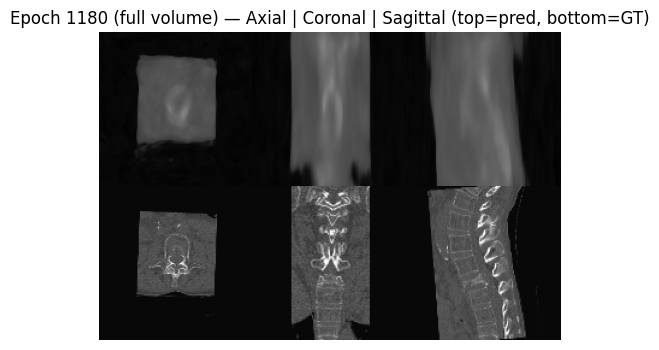

Checkpoint : checkpoints_model_mask/model_epoch1180.pt
Epoch 1181/4000 LR:8.61e-06 | MSE(subset):5.4433e-03 | PSNR~:22.64 dB
Epoch 1182/4000 LR:8.61e-06 | MSE(subset):5.4451e-03 | PSNR~:22.64 dB
Epoch 1183/4000 LR:8.60e-06 | MSE(subset):5.3654e-03 | PSNR~:22.70 dB
Epoch 1184/4000 LR:8.60e-06 | MSE(subset):5.3143e-03 | PSNR~:22.75 dB
Epoch 1185/4000 LR:8.60e-06 | MSE(subset):5.1982e-03 | PSNR~:22.84 dB
Epoch 1186/4000 LR:8.60e-06 | MSE(subset):5.2649e-03 | PSNR~:22.79 dB
Epoch 1187/4000 LR:8.60e-06 | MSE(subset):5.3709e-03 | PSNR~:22.70 dB
Epoch 1188/4000 LR:8.59e-06 | MSE(subset):5.4282e-03 | PSNR~:22.65 dB
Epoch 1189/4000 LR:8.59e-06 | MSE(subset):5.2901e-03 | PSNR~:22.77 dB
Epoch 1190/4000 LR:8.59e-06 | MSE(subset):5.3318e-03 | PSNR~:22.73 dB
Checkpoint : checkpoints_model_mask/model_epoch1190.pt
Epoch 1191/4000 LR:8.59e-06 | MSE(subset):5.2547e-03 | PSNR~:22.79 dB
Epoch 1192/4000 LR:8.58e-06 | MSE(subset):5.3438e-03 | PSNR~:22.72 dB
Epoch 1193/4000 LR:8.58e-06 | MSE(subset):5.2929e-

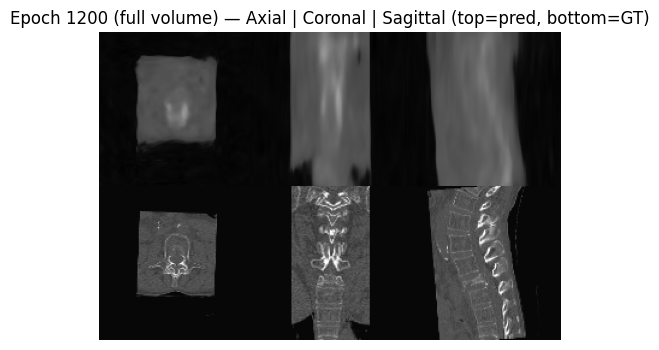

Checkpoint : checkpoints_model_mask/model_epoch1200.pt
Epoch 1201/4000 LR:8.57e-06 | MSE(subset):5.3034e-03 | PSNR~:22.75 dB
Epoch 1202/4000 LR:8.56e-06 | MSE(subset):5.3651e-03 | PSNR~:22.70 dB
Epoch 1203/4000 LR:8.56e-06 | MSE(subset):5.2900e-03 | PSNR~:22.77 dB
Epoch 1204/4000 LR:8.56e-06 | MSE(subset):5.2579e-03 | PSNR~:22.79 dB
Epoch 1205/4000 LR:8.56e-06 | MSE(subset):5.2567e-03 | PSNR~:22.79 dB
Epoch 1206/4000 LR:8.55e-06 | MSE(subset):5.3135e-03 | PSNR~:22.75 dB
Epoch 1207/4000 LR:8.55e-06 | MSE(subset):5.3812e-03 | PSNR~:22.69 dB
Epoch 1208/4000 LR:8.55e-06 | MSE(subset):5.3105e-03 | PSNR~:22.75 dB
Epoch 1209/4000 LR:8.55e-06 | MSE(subset):5.2566e-03 | PSNR~:22.79 dB
Epoch 1210/4000 LR:8.54e-06 | MSE(subset):5.4005e-03 | PSNR~:22.68 dB
Checkpoint : checkpoints_model_mask/model_epoch1210.pt
Epoch 1211/4000 LR:8.54e-06 | MSE(subset):5.3516e-03 | PSNR~:22.72 dB
Epoch 1212/4000 LR:8.54e-06 | MSE(subset):5.5277e-03 | PSNR~:22.57 dB
Epoch 1213/4000 LR:8.54e-06 | MSE(subset):5.4018e-

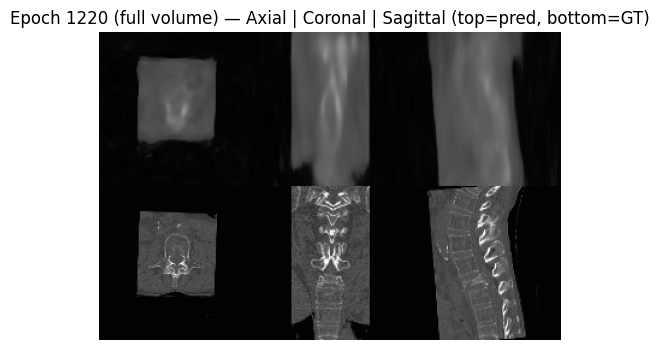

Checkpoint : checkpoints_model_mask/model_epoch1220.pt
Epoch 1221/4000 LR:8.52e-06 | MSE(subset):5.3070e-03 | PSNR~:22.75 dB
Epoch 1222/4000 LR:8.52e-06 | MSE(subset):5.2778e-03 | PSNR~:22.78 dB
Epoch 1223/4000 LR:8.52e-06 | MSE(subset):5.1932e-03 | PSNR~:22.85 dB
Epoch 1224/4000 LR:8.51e-06 | MSE(subset):5.2667e-03 | PSNR~:22.78 dB
Epoch 1225/4000 LR:8.51e-06 | MSE(subset):5.2893e-03 | PSNR~:22.77 dB
Epoch 1226/4000 LR:8.51e-06 | MSE(subset):5.3388e-03 | PSNR~:22.73 dB
Epoch 1227/4000 LR:8.51e-06 | MSE(subset):5.3131e-03 | PSNR~:22.75 dB
Epoch 1228/4000 LR:8.50e-06 | MSE(subset):5.2443e-03 | PSNR~:22.80 dB
Epoch 1229/4000 LR:8.50e-06 | MSE(subset):5.2557e-03 | PSNR~:22.79 dB
Epoch 1230/4000 LR:8.50e-06 | MSE(subset):5.3047e-03 | PSNR~:22.75 dB
Checkpoint : checkpoints_model_mask/model_epoch1230.pt
Epoch 1231/4000 LR:8.50e-06 | MSE(subset):5.2457e-03 | PSNR~:22.80 dB
Epoch 1232/4000 LR:8.50e-06 | MSE(subset):5.1055e-03 | PSNR~:22.92 dB
Epoch 1233/4000 LR:8.49e-06 | MSE(subset):5.1235e-

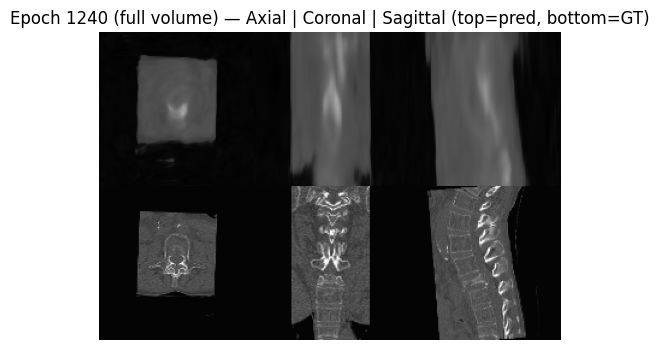

Checkpoint : checkpoints_model_mask/model_epoch1240.pt
Epoch 1241/4000 LR:8.48e-06 | MSE(subset):5.1649e-03 | PSNR~:22.87 dB
Epoch 1242/4000 LR:8.47e-06 | MSE(subset):5.2764e-03 | PSNR~:22.78 dB
Epoch 1243/4000 LR:8.47e-06 | MSE(subset):5.2124e-03 | PSNR~:22.83 dB
Epoch 1244/4000 LR:8.47e-06 | MSE(subset):5.3751e-03 | PSNR~:22.70 dB
Epoch 1245/4000 LR:8.47e-06 | MSE(subset):5.1644e-03 | PSNR~:22.87 dB
Epoch 1246/4000 LR:8.46e-06 | MSE(subset):5.2937e-03 | PSNR~:22.76 dB
Epoch 1247/4000 LR:8.46e-06 | MSE(subset):5.3286e-03 | PSNR~:22.73 dB
Epoch 1248/4000 LR:8.46e-06 | MSE(subset):5.3456e-03 | PSNR~:22.72 dB
Epoch 1249/4000 LR:8.46e-06 | MSE(subset):5.3060e-03 | PSNR~:22.75 dB
Epoch 1250/4000 LR:8.45e-06 | MSE(subset):5.4629e-03 | PSNR~:22.63 dB
Checkpoint : checkpoints_model_mask/model_epoch1250.pt
Epoch 1251/4000 LR:8.45e-06 | MSE(subset):5.3925e-03 | PSNR~:22.68 dB
Epoch 1252/4000 LR:8.45e-06 | MSE(subset):5.4213e-03 | PSNR~:22.66 dB
Epoch 1253/4000 LR:8.45e-06 | MSE(subset):5.4607e-

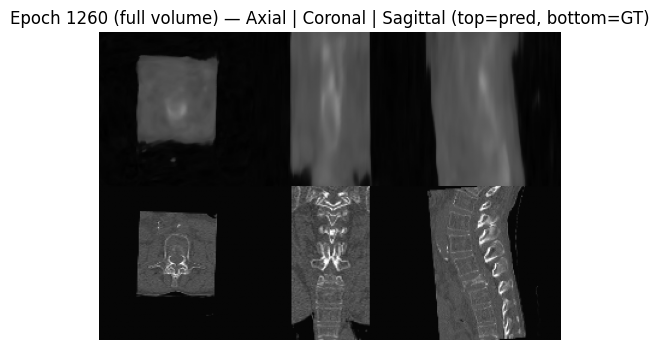

Checkpoint : checkpoints_model_mask/model_epoch1260.pt
Epoch 1261/4000 LR:8.43e-06 | MSE(subset):5.1085e-03 | PSNR~:22.92 dB
Epoch 1262/4000 LR:8.43e-06 | MSE(subset):5.2174e-03 | PSNR~:22.83 dB
Epoch 1263/4000 LR:8.42e-06 | MSE(subset):5.2256e-03 | PSNR~:22.82 dB
Epoch 1264/4000 LR:8.42e-06 | MSE(subset):5.2434e-03 | PSNR~:22.80 dB
Epoch 1265/4000 LR:8.42e-06 | MSE(subset):5.1437e-03 | PSNR~:22.89 dB
Epoch 1266/4000 LR:8.42e-06 | MSE(subset):5.2527e-03 | PSNR~:22.80 dB
Epoch 1267/4000 LR:8.42e-06 | MSE(subset):5.2855e-03 | PSNR~:22.77 dB
Epoch 1268/4000 LR:8.41e-06 | MSE(subset):5.1002e-03 | PSNR~:22.92 dB
Epoch 1269/4000 LR:8.41e-06 | MSE(subset):5.1193e-03 | PSNR~:22.91 dB
Epoch 1270/4000 LR:8.41e-06 | MSE(subset):5.0724e-03 | PSNR~:22.95 dB
Checkpoint : checkpoints_model_mask/model_epoch1270.pt
Epoch 1271/4000 LR:8.41e-06 | MSE(subset):5.1574e-03 | PSNR~:22.88 dB
Epoch 1272/4000 LR:8.40e-06 | MSE(subset):5.1768e-03 | PSNR~:22.86 dB
Epoch 1273/4000 LR:8.40e-06 | MSE(subset):5.1568e-

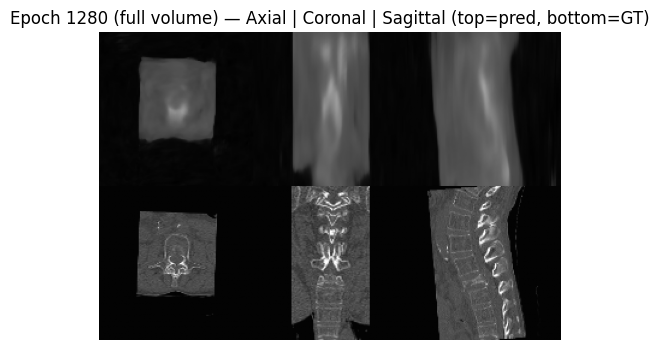

Checkpoint : checkpoints_model_mask/model_epoch1280.pt
Epoch 1281/4000 LR:8.38e-06 | MSE(subset):5.2573e-03 | PSNR~:22.79 dB
Epoch 1282/4000 LR:8.38e-06 | MSE(subset):5.1900e-03 | PSNR~:22.85 dB
Epoch 1283/4000 LR:8.38e-06 | MSE(subset):5.2595e-03 | PSNR~:22.79 dB
Epoch 1284/4000 LR:8.38e-06 | MSE(subset):5.1319e-03 | PSNR~:22.90 dB
Epoch 1285/4000 LR:8.37e-06 | MSE(subset):5.3461e-03 | PSNR~:22.72 dB
Epoch 1286/4000 LR:8.37e-06 | MSE(subset):5.3057e-03 | PSNR~:22.75 dB
Epoch 1287/4000 LR:8.37e-06 | MSE(subset):5.1520e-03 | PSNR~:22.88 dB
Epoch 1288/4000 LR:8.37e-06 | MSE(subset):5.1838e-03 | PSNR~:22.85 dB
Epoch 1289/4000 LR:8.36e-06 | MSE(subset):5.1857e-03 | PSNR~:22.85 dB
Epoch 1290/4000 LR:8.36e-06 | MSE(subset):5.2149e-03 | PSNR~:22.83 dB
Checkpoint : checkpoints_model_mask/model_epoch1290.pt
Epoch 1291/4000 LR:8.36e-06 | MSE(subset):5.1635e-03 | PSNR~:22.87 dB
Epoch 1292/4000 LR:8.36e-06 | MSE(subset):5.1536e-03 | PSNR~:22.88 dB
Epoch 1293/4000 LR:8.36e-06 | MSE(subset):5.2488e-

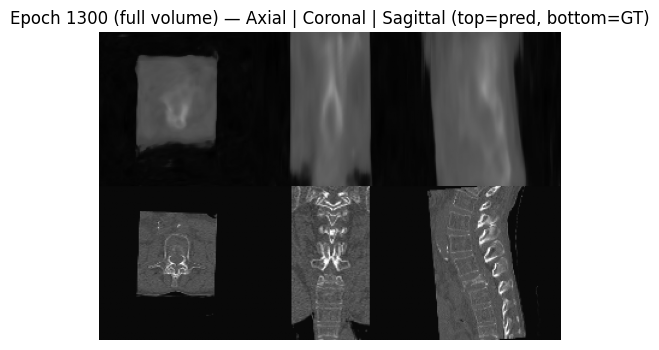

Checkpoint : checkpoints_model_mask/model_epoch1300.pt
Epoch 1301/4000 LR:8.34e-06 | MSE(subset):5.2191e-03 | PSNR~:22.82 dB
Epoch 1302/4000 LR:8.33e-06 | MSE(subset):5.0850e-03 | PSNR~:22.94 dB
Epoch 1303/4000 LR:8.33e-06 | MSE(subset):5.0973e-03 | PSNR~:22.93 dB
Epoch 1304/4000 LR:8.33e-06 | MSE(subset):5.2264e-03 | PSNR~:22.82 dB
Epoch 1305/4000 LR:8.33e-06 | MSE(subset):5.1302e-03 | PSNR~:22.90 dB
Epoch 1306/4000 LR:8.32e-06 | MSE(subset):5.1184e-03 | PSNR~:22.91 dB
Epoch 1307/4000 LR:8.32e-06 | MSE(subset):5.1521e-03 | PSNR~:22.88 dB
Epoch 1308/4000 LR:8.32e-06 | MSE(subset):5.2531e-03 | PSNR~:22.80 dB
Epoch 1309/4000 LR:8.32e-06 | MSE(subset):5.1988e-03 | PSNR~:22.84 dB
Epoch 1310/4000 LR:8.32e-06 | MSE(subset):5.2286e-03 | PSNR~:22.82 dB
Checkpoint : checkpoints_model_mask/model_epoch1310.pt
Epoch 1311/4000 LR:8.31e-06 | MSE(subset):5.1449e-03 | PSNR~:22.89 dB
Epoch 1312/4000 LR:8.31e-06 | MSE(subset):5.1688e-03 | PSNR~:22.87 dB
Epoch 1313/4000 LR:8.31e-06 | MSE(subset):5.2953e-

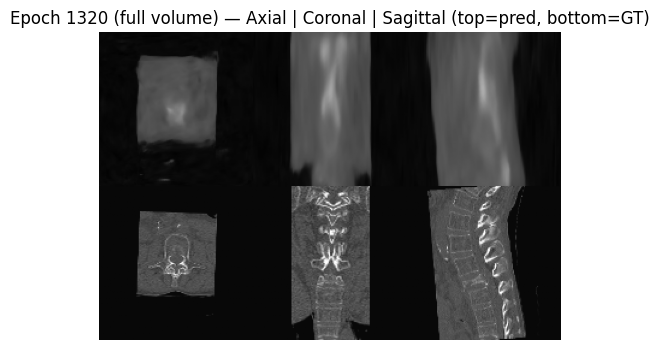

Checkpoint : checkpoints_model_mask/model_epoch1320.pt
Epoch 1321/4000 LR:8.29e-06 | MSE(subset):5.2817e-03 | PSNR~:22.77 dB
Epoch 1322/4000 LR:8.29e-06 | MSE(subset):5.2841e-03 | PSNR~:22.77 dB
Epoch 1323/4000 LR:8.28e-06 | MSE(subset):5.1872e-03 | PSNR~:22.85 dB
Epoch 1324/4000 LR:8.28e-06 | MSE(subset):5.2060e-03 | PSNR~:22.83 dB
Epoch 1325/4000 LR:8.28e-06 | MSE(subset):5.2353e-03 | PSNR~:22.81 dB
Epoch 1326/4000 LR:8.28e-06 | MSE(subset):5.1512e-03 | PSNR~:22.88 dB
Epoch 1327/4000 LR:8.28e-06 | MSE(subset):5.1665e-03 | PSNR~:22.87 dB
Epoch 1328/4000 LR:8.27e-06 | MSE(subset):5.0444e-03 | PSNR~:22.97 dB
Epoch 1329/4000 LR:8.27e-06 | MSE(subset):5.2300e-03 | PSNR~:22.81 dB
Epoch 1330/4000 LR:8.27e-06 | MSE(subset):5.1682e-03 | PSNR~:22.87 dB
Checkpoint : checkpoints_model_mask/model_epoch1330.pt
Epoch 1331/4000 LR:8.27e-06 | MSE(subset):5.1233e-03 | PSNR~:22.90 dB
Epoch 1332/4000 LR:8.26e-06 | MSE(subset):5.0426e-03 | PSNR~:22.97 dB
Epoch 1333/4000 LR:8.26e-06 | MSE(subset):5.1073e-

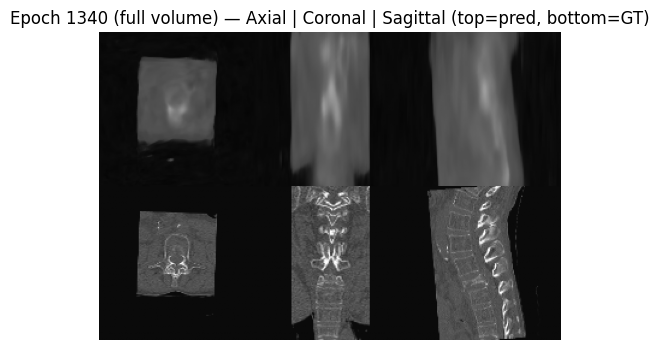

Checkpoint : checkpoints_model_mask/model_epoch1340.pt
Epoch 1341/4000 LR:8.24e-06 | MSE(subset):5.1393e-03 | PSNR~:22.89 dB
Epoch 1342/4000 LR:8.24e-06 | MSE(subset):5.1419e-03 | PSNR~:22.89 dB
Epoch 1343/4000 LR:8.24e-06 | MSE(subset):5.1241e-03 | PSNR~:22.90 dB
Epoch 1344/4000 LR:8.23e-06 | MSE(subset):5.1954e-03 | PSNR~:22.84 dB
Epoch 1345/4000 LR:8.23e-06 | MSE(subset):5.2343e-03 | PSNR~:22.81 dB
Epoch 1346/4000 LR:8.23e-06 | MSE(subset):5.2378e-03 | PSNR~:22.81 dB
Epoch 1347/4000 LR:8.23e-06 | MSE(subset):5.1685e-03 | PSNR~:22.87 dB
Epoch 1348/4000 LR:8.23e-06 | MSE(subset):5.1062e-03 | PSNR~:22.92 dB
Epoch 1349/4000 LR:8.22e-06 | MSE(subset):5.1834e-03 | PSNR~:22.85 dB
Epoch 1350/4000 LR:8.22e-06 | MSE(subset):5.2449e-03 | PSNR~:22.80 dB
Checkpoint : checkpoints_model_mask/model_epoch1350.pt
Epoch 1351/4000 LR:8.22e-06 | MSE(subset):5.2624e-03 | PSNR~:22.79 dB
Epoch 1352/4000 LR:8.22e-06 | MSE(subset):5.0757e-03 | PSNR~:22.95 dB
Epoch 1353/4000 LR:8.21e-06 | MSE(subset):5.0240e-

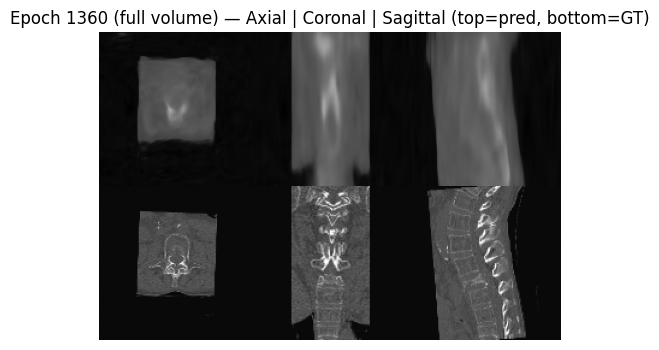

Checkpoint : checkpoints_model_mask/model_epoch1360.pt
Epoch 1361/4000 LR:8.19e-06 | MSE(subset):5.2264e-03 | PSNR~:22.82 dB
Epoch 1362/4000 LR:8.19e-06 | MSE(subset):5.1505e-03 | PSNR~:22.88 dB
Epoch 1363/4000 LR:8.19e-06 | MSE(subset):5.2035e-03 | PSNR~:22.84 dB
Epoch 1364/4000 LR:8.19e-06 | MSE(subset):5.1580e-03 | PSNR~:22.88 dB
Epoch 1365/4000 LR:8.18e-06 | MSE(subset):5.2590e-03 | PSNR~:22.79 dB
Epoch 1366/4000 LR:8.18e-06 | MSE(subset):5.3042e-03 | PSNR~:22.75 dB
Epoch 1367/4000 LR:8.18e-06 | MSE(subset):5.3366e-03 | PSNR~:22.73 dB
Epoch 1368/4000 LR:8.18e-06 | MSE(subset):5.2443e-03 | PSNR~:22.80 dB
Epoch 1369/4000 LR:8.17e-06 | MSE(subset):5.1563e-03 | PSNR~:22.88 dB
Epoch 1370/4000 LR:8.17e-06 | MSE(subset):5.0691e-03 | PSNR~:22.95 dB
Checkpoint : checkpoints_model_mask/model_epoch1370.pt
Epoch 1371/4000 LR:8.17e-06 | MSE(subset):5.1153e-03 | PSNR~:22.91 dB
Epoch 1372/4000 LR:8.17e-06 | MSE(subset):5.1089e-03 | PSNR~:22.92 dB
Epoch 1373/4000 LR:8.17e-06 | MSE(subset):5.0826e-

KeyboardInterrupt: 

In [10]:
train_model_new(model, optimG, make_scheduler, CKPT_DIR, resume_epoch=None)